In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns


In [24]:
df = pd.DataFrame()

In [25]:
def get_clean_data(name):
    input_df = pd.read_csv(name + '.csv', header=None)
    
    before_len = len(input_df)
    input_df = input_df[(input_df[1] == 302) & (input_df[2] == 302)]
    print(str(before_len - len(input_df)) + " of " + str(before_len) + " rows with unexpected http codes removed from " + name + ".csv")

    before_len = len(input_df)
    input_df = input_df[(np.abs(stats.zscore(input_df[0])) < 3)]
    print(str(before_len - len(input_df)) + " of " + str(before_len) + " rows with outliers removed from " + name + ".csv")
    
    return input_df[0]

for name in ['target_local', 'control_local', 'target_remote', 'control_remote']:
    df[name] = get_clean_data(name)

0 of 325 rows with unexpected http codes removed from target_local.csv
1 of 325 rows with outliers removed from target_local.csv
0 of 30 rows with unexpected http codes removed from control_local.csv
0 of 30 rows with outliers removed from control_local.csv
2 of 12 rows with unexpected http codes removed from target_remote.csv
0 of 10 rows with outliers removed from target_remote.csv
0 of 40 rows with unexpected http codes removed from control_remote.csv
1 of 40 rows with outliers removed from control_remote.csv


<Axes: ylabel='Density'>

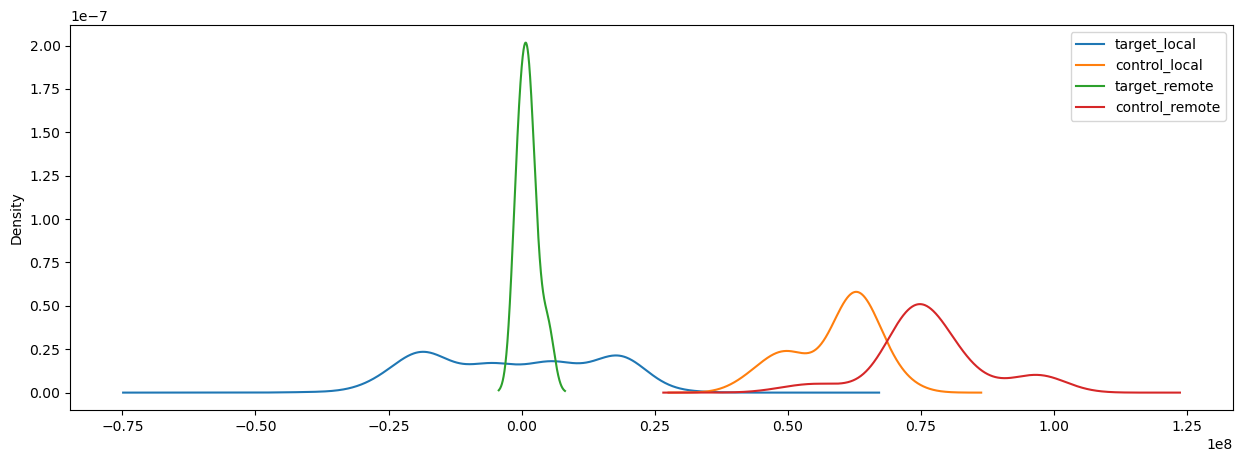

In [26]:
df.plot(kind='kde', figsize=(15,5))

# Create the distribution plot using Seaborn's displot
# sns.displot(data=df[:100], kind='kde')

# # Add vertical lines
# plt.axvline(x=1, color='grey', linestyle='--')

# plt.show()

In [9]:
df.mean()

target_local     -1.487501e+06
control_local     6.230952e+07
target_remote    -1.137227e+07
control_remote    7.641260e+07
dtype: float64

In [39]:
df['control'].max()

115257049.0